# This notebook is an example notebook to inference the latent diffusion model.

In [13]:
import os
import sys
sys.path.append(os.getcwd()+"/ldm")
from omegaconf import OmegaConf
from PIL import Image, ImageDraw
import numpy as np
import torch
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
import os
import sys
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
import os
import torch
import random
import matplotlib.pyplot as plt

import torchvision.transforms as T
transform_PIL = T.ToPILImage()

In [14]:
# config
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
yaml_path="ldm/models/ldm/inpainting_big/config.yaml"
model_path="ldm/models/ldm/inpainting_big/last.ckpt"

In [15]:
##create model
def create_model(device):
    
    #load config and checkpoint
    config = OmegaConf.load(yaml_path)
    config.model['params']['ckpt_path']=model_path
    
    model = instantiate_from_config(config.model)
    sampler = DDIMSampler(model)
    model = model.to(device)

    return model,sampler

In [16]:
def random_rectangle_mask(image):
    # Create a copy of the original image
    masked_image = image.copy()
    image_x, image_y = image.size
    
    width = random.randint(70, 150)
    height = int(width * random.uniform(0.7, 1.5))
    
    # Create a black background mask
    mask = Image.new('L', (image_x, image_y), 0)
    draw = ImageDraw.Draw(mask)

    # Randomly generate the coordinates for the top-left and bottom-right corners of the rectangle
    x1 = random.randint(0, image.size[0] - width)
    y1 = random.randint(0, image.size[1] - height)
    x2 = x1 + width
    y2 = y1 + height

    # Draw a white rectangle on the mask
    draw.rectangle([x1, y1, x2, y2], fill=255)

    # Apply the mask to the original image
    masked_image.paste(Image.new('RGB', (image_x, image_y), (0, 0, 0)), mask=mask)

    return image, mask, masked_image

In [17]:
def process_data(image,mask):

    # creating a 3 dimensional mask
    mask = np.array(mask)
    mask = np.expand_dims(mask, axis=2)

    # normalzie and transform the image into tensor
    image = np.array(image.convert("RGB"))
    image = image.astype(np.float32) / 255.0#
    image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)

    # normalzie and transform the mask into tensor
    mask = mask.astype(np.float32) / 255.0#
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask[None].transpose(0,3,1,2)

    # produce the masked image by subtraction
    mask = torch.from_numpy(mask)
    masked_image = (1 - mask) * image

    batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": masked_image}
    for k in batch:
        batch[k] = batch[k] * 2.0 - 1.0

    return batch

In [20]:
model,sampler=create_model(device)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 387.25 M params.
Keeping EMAs of 418.
making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels
Using first stage also as cond stage.


/Users/gireg.roussel/Desktop/octo/latent-diffusion-inpainting/ldm/ldm/models/diffusion/ddpm.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(path, map_l

FileNotFoundError: [Errno 2] No such file or directory: 'ldm/models/ldm/inpainting_big/last.ckpt'

In [ ]:
load_image=Image.open("./example_data/5bf0393a-daf5-4803-85c7-abb1f7640894.jpg").resize((512,512))

In [ ]:
image,mask,masked_image=random_rectangle_mask(load_image)

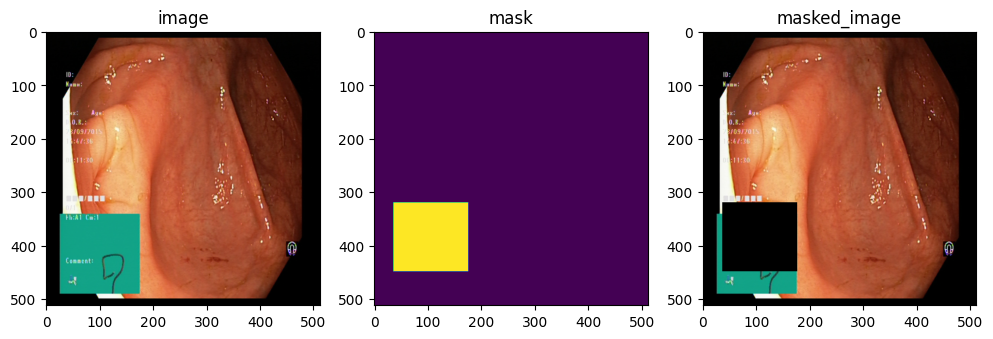

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('image')

axes[1].imshow(mask)
axes[1].set_title('mask')

axes[2].imshow(masked_image)
axes[2].set_title('masked_image')

plt.show()

In [ ]:
##Inference

# convert PIL image into input Torch Tensor
batch=process_data(image,mask)
image_tensor=batch["image_tensor"]
mask_tensor=batch["mask_tensor"]
masked_image_tensor=batch["masked_image_tensor"]


# encode masked image and concat downsampled mask
c = model.cond_stage_model.encode(masked_image_tensor.to(device))

# the mask is frst being downsampled
cc = torch.nn.functional.interpolate(mask_tensor.to(device),
                                    size=c.shape[-2:])
# concat the masked image and downsampled mask
c = torch.cat((c, cc), dim=1)
shape = (c.shape[1]-1,)+c.shape[2:]

# diffusion process
samples_ddim, _ = sampler.sample(S=50,
                             conditioning=c,
                             batch_size=c.shape[0],
                             shape=shape,
                             verbose=False)

# decode the latent vector (output)
x_samples_ddim = model.decode_first_stage(samples_ddim)


# denormalize the output
predicted_image_clamped = torch.clamp((x_samples_ddim+1.0)/2.0,
                            min=0.0, max=1.0)

Data shape for DDIM sampling is (1, 3, 128, 128), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


In [ ]:
output_PIL=transform_PIL(predicted_image_clamped[0])

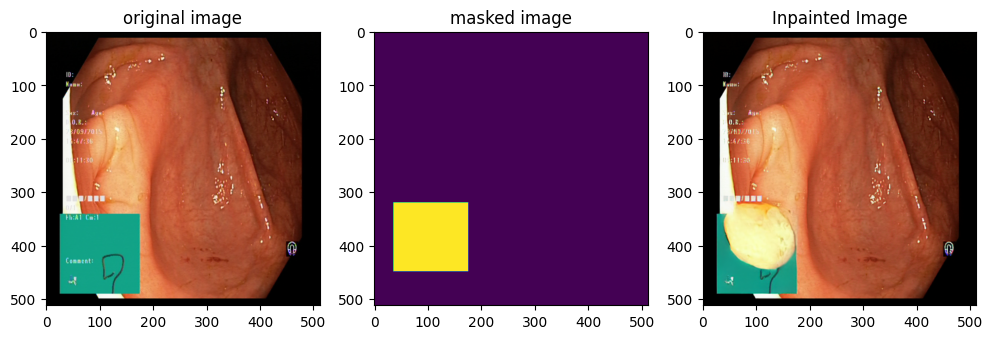

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('original image')

axes[1].imshow(mask)
axes[1].set_title('masked image')

axes[2].imshow(output_PIL)
axes[2].set_title('Inpainted Image')

plt.show()